<a href="https://colab.research.google.com/github/emrullahozkilinc/machine-learning/blob/master/lstm_btc_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as splitter
import requests

In [2]:
api_key = 'DYYIZJLWV1FF48MZ'
symbol = 'BTC'
period = 'DIGITAL_CURRENCY_DAILY'
ret_type = 'USD'
URL = 'https://www.alphavantage.co/query?function=%s&symbol=%s&market=%s&outputsize=full&apikey=%s'%(period, symbol, ret_type, api_key)
file_to_save = 'stock_market_data-%s.csv'%symbol

if not os.path.exists(file_to_save):
  with urllib.request.urlopen(URL) as urll:
    data = json.loads(urll.read().decode())
    data = data['Time Series (Digital Currency Daily)']
    df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
    for k,v in data.items():
      date = dt.datetime.strptime(k, '%Y-%m-%d')
      data_row = [date.date(), float(v['3a. low (USD)']), float(v['2a. high (USD)']), 
                  float(v['4a. close (USD)']), float(v['1b. open (USD)'])]
      df.loc[-1,:] = data_row
      df.index = df.index + 1

  print('Data saved to : %s'%file_to_save)        
  df.to_csv(file_to_save)  
else:
  print('File already exists. Loading data from CSV')
  df = pd.read_csv(file_to_save)

Data saved to : stock_market_data-BTC.csv


In [3]:
df = df.sort_values('Date')

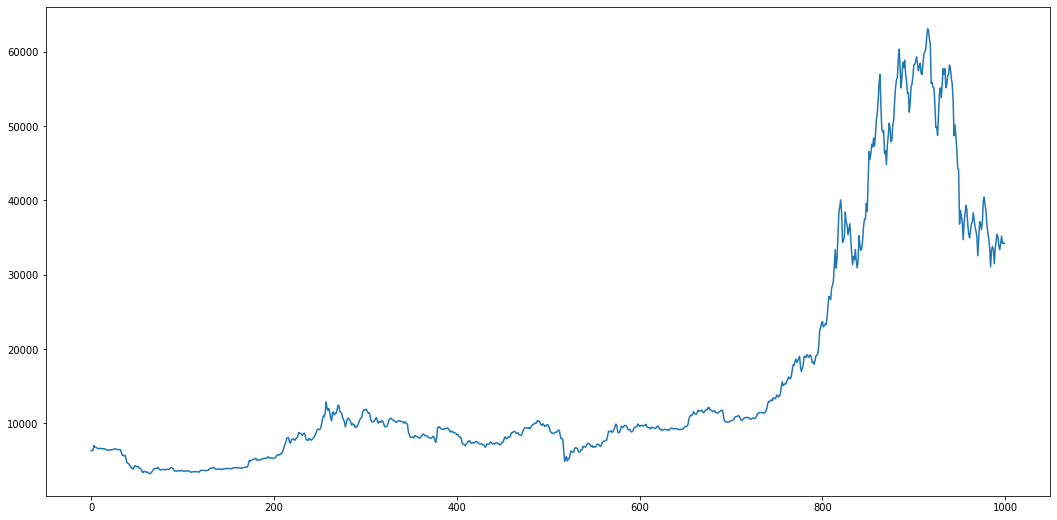

In [6]:
plt.figure(figsize=(18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)

In [56]:
mid_price = (df.loc[:,'High']+df.loc[:,'Low'])/2

In [57]:
mid_price = mid_price.values

In [60]:
train, validation, test = mid_price[:700], mid_price[700:851], mid_price[850:]

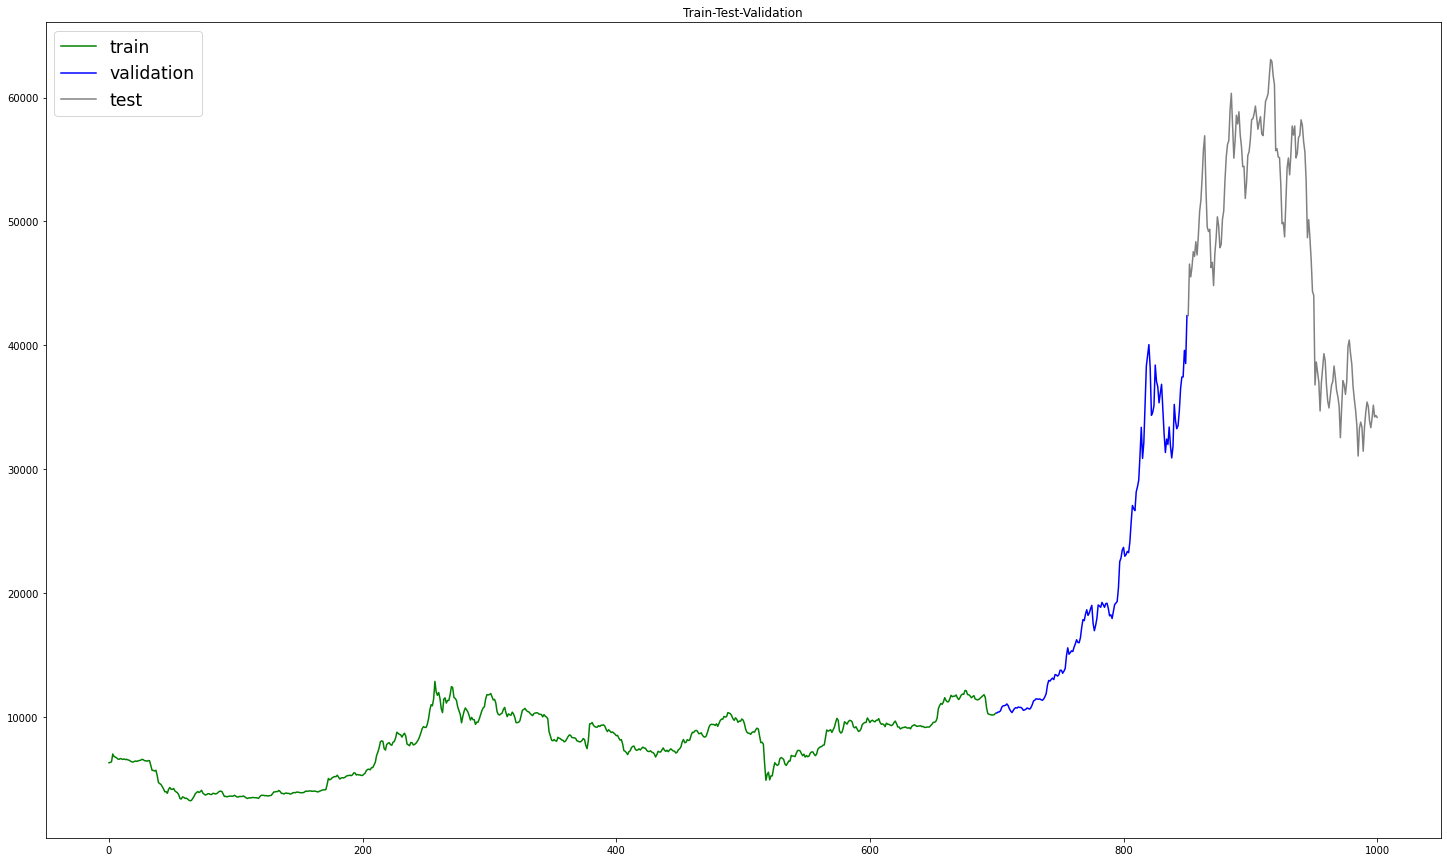

In [67]:
plt.figure(figsize=(25,15))
plt.plot(range(len(train)), train, color = 'green', label = 'train')
plt.plot(range(len(train), len(train)+len(validation)), validation, color = 'blue',label = 'validation')
plt.plot(range(len(train)+len(validation), 
               len(train)+len(validation)+len(test)), test, color = 'grey', label='test')
plt.title('Train-Test-Validation')
plt.legend(loc = 'upper left', fontsize='xx-large')
plt.show()

In [46]:
train = train.reshape(-1,1)
validation = validation.reshape(-1,1)
test = test.reshape(-1,1)

In [47]:
scaler = MinMaxScaler()
frame_size = 150

for z in range(0,600,frame_size):
  scaler.fit(train[z:z+frame_size,:])
  train[z:z+frame_size,:] = scaler.transform(train[z:z+frame_size,:])

scaler.fit(train[z+frame_size:,:])
train[z+frame_size:,:] = scaler.transform(train[z+frame_size:,:])